In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm

In [2]:
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [3]:
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,[CH000197],1,16,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,[CH000221],1,1,[AT000002]
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,[CH000215],1,2,"[AT000002, AT000003, CH000221]"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,[CH000227],1,1,[AT000004]
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,[CH000214],1,3,"[AT000005, CH000214]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,[UAGR0017]
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,[UAGR0018]
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,[UAGR0019]


In [4]:
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,[AT000002]
AT000003,"[AT000002, AT000003, CH000221]"
AT000004,[AT000004]
AT000005,"[AT000005, CH000214]"
...,...
UAGR0017,[UAGR0017]
UAGR0018,[UAGR0018]
UAGR0019,[UAGR0019]


In [5]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [6]:
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [7]:
from utils.functions import find_max_unique_rows

# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["DEBU1959"]

100%|██████████| 1/1 [00:00<00:00, 130.61it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.585,0.0,0.0,0.0,0.00,0.00,8.920,0.000,0.075,8.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.577,0.0,0.0,0.0,0.00,0.00,6.106,0.000,0.000,6.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.661,0.0,0.0,0.0,0.00,0.00,6.996,0.200,0.605,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,0.544,1.0,1.0,2.0,1.80,62.62,5.680,0.045,0.045,25.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,0.567,2.0,2.0,6.0,2.67,67.85,4.753,1.641,4.770,78.0


In [8]:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]
estreams_attributes_clipped

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.566,0.0,0.0,0.0,0.00,0.00,7.497,1.400,3.429,16.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.585,0.0,0.0,0.0,0.00,0.00,8.920,0.000,0.075,8.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.577,0.0,0.0,0.0,0.00,0.00,6.106,0.000,0.000,6.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.640,0.0,0.0,0.0,0.00,0.00,7.096,1.200,2.427,9.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.661,0.0,0.0,0.0,0.00,0.00,6.996,0.200,0.605,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,0.544,1.0,1.0,2.0,1.80,62.62,5.680,0.045,0.045,25.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.489,0.0,0.0,0.0,0.00,0.00,2.863,0.004,0.009,15.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,0.567,2.0,2.0,6.0,2.67,67.85,4.753,1.641,4.770,78.0


In [183]:
estreams_attributes_clipped[estreams_attributes_clipped.gauges_upstream <= 1].index.tolist()

['BEWA0067',
 'BEWA0087',
 'BEWA0106',
 'BEWA0107',
 'DERP2005',
 'DERP2006',
 'DERP2008',
 'DERP2013',
 'DERP2016',
 'DERP2028',
 'DERP2030',
 'DERP2031',
 'DERP2036',
 'FR000124',
 'FR000126',
 'FR000132',
 'FR000136',
 'FR000137',
 'FR000143',
 'FR000144',
 'FR000151',
 'FR000160',
 'FR000169',
 'FR000174',
 'FR000183',
 'FR000184',
 'FR000187',
 'FR000198',
 'FR000201',
 'FR003234',
 'FR003238',
 'FR003239',
 'FR003243',
 'FR003247',
 'FR003250',
 'FR003255',
 'FR003263',
 'FR003266',
 'FR003267',
 'FR003268',
 'FR003290',
 'FR003294',
 'FR003303',
 'FR003306',
 'LU000002',
 'LU000004',
 'LU000010',
 'LU000018']

In [10]:
#basin_id = "FR000702"
#basin_id = "PL000700"
basin_id = "FR000154"
basin_id = "CH000001"
basin_id = "FR003237" # Epinal
#basin_id = "DERP2004" # GemuendOur
#basin_id = "DERP2007" # Pruemzurlay
basin_id = "DERP2023"
basin_id = "LU000011"
basin_id = "LU000001"
basin_id = "LU000007" #Ettelbruck
basin_id = "LU000015" #Michelau
basin_id = "DERP2004" 
#basin_id = "FR003237" # Epinal

#basin_id = "PT000102" 

#basin_id = "ITVE0429" 
#basin_id = "FR003253" # Luneville



In [11]:
estreams_attributes_clipped.loc[basin_id, :].head(30)

gauge_id                                                      2626030300
gauge_name                                                    GemuendOur
gauge_country                                                         DE
gauge_provider                                                     DE_RP
river                                                                Our
lon_snap                                                           6.171
lat_snap                                                          49.985
lon                                                                6.171
lat                                                               49.985
elevation                                                            NaN
area_official                                                      613.4
area_estreams                                                      615.0
area_flag                                                              0
area_rel                                           

In [12]:
estreams_attributes_clipped.loc[basin_id, "baseflow_index":]

baseflow_index             0.5
hfd_mean               127.574
hfd_std                 19.292
q_5                      0.084
q_95                      4.65
                        ...   
lakes_tot_vol              0.0
sno_cov_mean             6.721
irri_1990                1.495
irri_2005                3.524
stations_num_p_mean       25.0
Name: DERP2004, Length: 86, dtype: object

In [184]:
catchments_ids = [
    "FR003237", "DERP2004", "FR003253",'BEWA0067',
 'BEWA0087',
 'BEWA0106',
 'BEWA0107'
]


# Initialize the dictionary
inputs = {}
observations = {}
areas = {}

for basin_id in catchments_ids:
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area


False
False
False


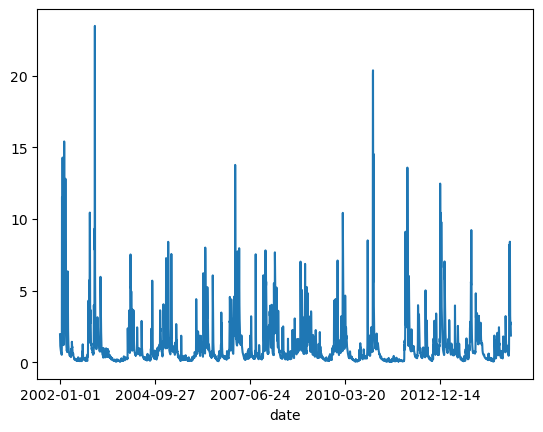

In [121]:
data.Q.plot()
print(data.p_mean.isnull().values.any())
print(data.pet_mean.isnull().values.any())
print(data.t_mean.isnull().values.any())

In [185]:
inputs

{'FR003237': [array([0.  , 0.  , 0.  , ..., 3.03, 0.  , 0.  ]),
  array([-6.22, -4.5 , -4.65, ..., -8.69, -3.55, -1.59]),
  array([0.28, 0.36, 0.34, ..., 0.22, 0.23, 0.23])],
 'DERP2004': [array([0.  , 0.  , 0.  , ..., 1.67, 0.  , 0.15]),
  array([-4.55, -4.84, -5.27, ..., -2.85, -0.13,  0.11]),
  array([0.23, 0.32, 0.19, ..., 0.31, 0.25, 0.26])],
 'FR003253': [array([0.  , 0.  , 0.  , ..., 2.93, 0.  , 0.  ]),
  array([-6.3 , -5.02, -5.2 , ..., -7.74, -2.8 , -1.17]),
  array([0.27, 0.33, 0.29, ..., 0.24, 0.23, 0.22])],
 'BEWA0067': [array([0. , 0. , 0. , ..., 1.6, 0. , 0.2]),
  array([-4.5 , -4.06, -5.6 , ..., -3.1 , -0.49,  0.  ]),
  array([0.21, 0.29, 0.2 , ..., 0.28, 0.23, 0.23])],
 'BEWA0087': [array([0. , 0. , 0. , ..., 1.3, 0. , 0.5]),
  array([-5.2 , -6.54, -5.78, ..., -4.09, -0.09,  0.09]),
  array([0.22, 0.29, 0.23, ..., 0.32, 0.26, 0.27])],
 'BEWA0106': [array([0. , 0. , 0. , ..., 1.7, 0. , 0. ]),
  array([-4.71, -5.29, -5.23, ..., -2.81,  0.  ,  0.12]),
  array([0.24, 0.33, 

In [160]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [169]:
#root_finder = PegasusPython()
#num_app = ImplicitEulerPython(root_finder=root_finder)

root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter2 = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.6},
    id='lowersplitter'
)


# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter2],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

DERP2004 = Node(
    units=[general],
    weights=[1.0],
    area=615.0,
    id='DERP2004'
)

FR003237 = Node(
    units=[general],
    weights=[1.0],
    area=1218.14,
    id='FR003237'
)

FR003253 = Node(
    units=[general],
    weights=[1.0],
    area=1102.95,
    id='FR003253'
)


catchments = [FR003237, DERP2004, FR003253]

model = Network(
    nodes=[
        DERP2004,
        FR003237,
        FR003253,
    ],
    topology={
        'DERP2004': None,
        'FR003237': None,
        'FR003253': None,
    }
)

In [199]:
# Generate nodes dynamically
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[general],  
        weights=[1.0],  
        area=areas.get(cat_id),  # Use default area if not in dictionary
        id=cat_id  
    )
    catchments.append(node)  # Append each created Node to the list

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology={cat_id: None for cat_id in catchments_ids}  # Simple topology (no upstream)
)


In [200]:
model

Module: superflexPy
Network class
Nodes:
	['FR003237', 'DERP2004', 'FR003253', 'BEWA0067', 'BEWA0087', 'BEWA0106', 'BEWA0107']
Network:
	{'FR003237': None, 'DERP2004': None, 'FR003253': None, 'BEWA0067': None, 'BEWA0087': None, 'BEWA0106': None, 'BEWA0107': None}
********************
********************
********************
Module: superflexPy
Node: FR003237
Units:
	['M4']
Weights:
	[1.0]
********************
********************
Module: superflexPy
Unit: M4
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	M4_snow_t0 : 0.0
	M4_snow_k : 0.01
	M4_snow_m : 2.0
States:
	FR003237_M4_snow_S0 : 0.0

********************
Module: superfle

In [224]:
# Set inputs for each node using the manually defined dictionary
for cat in catchments:

    cat.set_input(inputs[cat.id])  # Correct way to set inputs

In [225]:
import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, model, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):
    #def __init__(self, model, catchments, inputs, dt, observations, parameters, parameter_names, output_index, warm_up=365):

        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            model (Network): SuperflexPy network containing multiple nodes.
            catchments (list): List of Node objects.
            inputs (dict): Dictionary with inputs for each node.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._model = model  # The SuperflexPy network
        self._catchments = catchments  # List of catchments
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store inputs and observations for each node
        #self._inputs = inputs  # Dictionary {node_id: input_data}
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the entire network using the same parameter set and collects per-node outputs."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        # Apply shared parameters to the whole network
        self._model.set_parameters(named_parameters)

        ## Set inputs for each node using the manually defined dictionary
        #for cat in self._catchments:
        #    if cat.id in self._inputs:
        #        cat.set_input(self._inputs[cat.id])  # Correct way to set inputs

        # Set timestep and reset the network
        self._model.set_timestep(self._dt)
        self._model.reset_states()

        # Run the full network
        output = self._model.get_output()  # Get outputs for all nodes

        # Return outputs as a list (one per node)
        return [output[cat.id][self._output_index] for cat in self._catchments]



    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for sim, cat in zip(simulation, self._catchments):
            node_id = cat.id
            obs = evaluation[node_id]

            # Apply warm-up period
            sim = sim[self._warm_up + 1:]
            obs = obs[self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error



In [ ]:
spotpy_hyd_mod = spotpy_model(
    model=model,  # The entire SuperflexPy network
    catchments=catchments,  # Use predefined catchments list
    dt=1.0,  # Time step
    observations=observations,  # Observed data per node
    parameters=[
        spotpy.parameter.Uniform("M4_fast_k", 1e-5, 1.0),
        spotpy.parameter.Uniform("M4_slow_k", 1e-8, 0.1),
        spotpy.parameter.Uniform("M4_unsaturated_Ce", 0.1, 3.0),
        spotpy.parameter.Uniform("M4_unsaturated_m", 0.01, 1.0),
        spotpy.parameter.Uniform("M4_unsaturated_beta", 0.1, 10.0),
        spotpy.parameter.Uniform("M4_lowersplitter_split-par", 0.5, 0.9),
        spotpy.parameter.Uniform("M4_lag-fun_lag-time", 1.0, 4.0),
    ],
    parameter_names=[
        "M4_fast_k", "M4_slow_k", "M4_unsaturated_Ce", "M4_unsaturated_m",
        "M4_unsaturated_beta", "M4_lowersplitter_split-par", "M4_lag-fun_lag-time"
    ],
    output_index=0,  # Assumes all nodes have the same output variable
    warm_up=365  # Warm-up period
)

In [228]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=100)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
7 of 100, minimal objective function=3.53464, time remaining: 00:00:24
15 of 100, minimal objective function=2.20966, time remaining: 00:00:23
22 of 100, minimal objective function=1.98517, time remaining: 00:00:21
29 of 100, minimal objective function=1.98517, time remaining: 00:00:20
36 of 100, minimal objective function=1.98517, time remaining: 00:00:18
43 of 100, minimal objective function=1.98517, time remaining: 00:00:16
50 of 100, minimal objective function=1.98517, time remaining: 00:00:14
57 of 100, minimal objective function=1.98517, time remaining: 00:00:12
64 of 100, minimal objective function=1.98517, time remaining: 00:00:10
71 of 100, minimal objective function=1.98517, time remaining: 00:00:08
78 of 100, minimal objective function=1.98517, tim

The figure as been saved as "Parameter_trace.png
Run number 88 has the lowest objectivefunction with: 1.9817


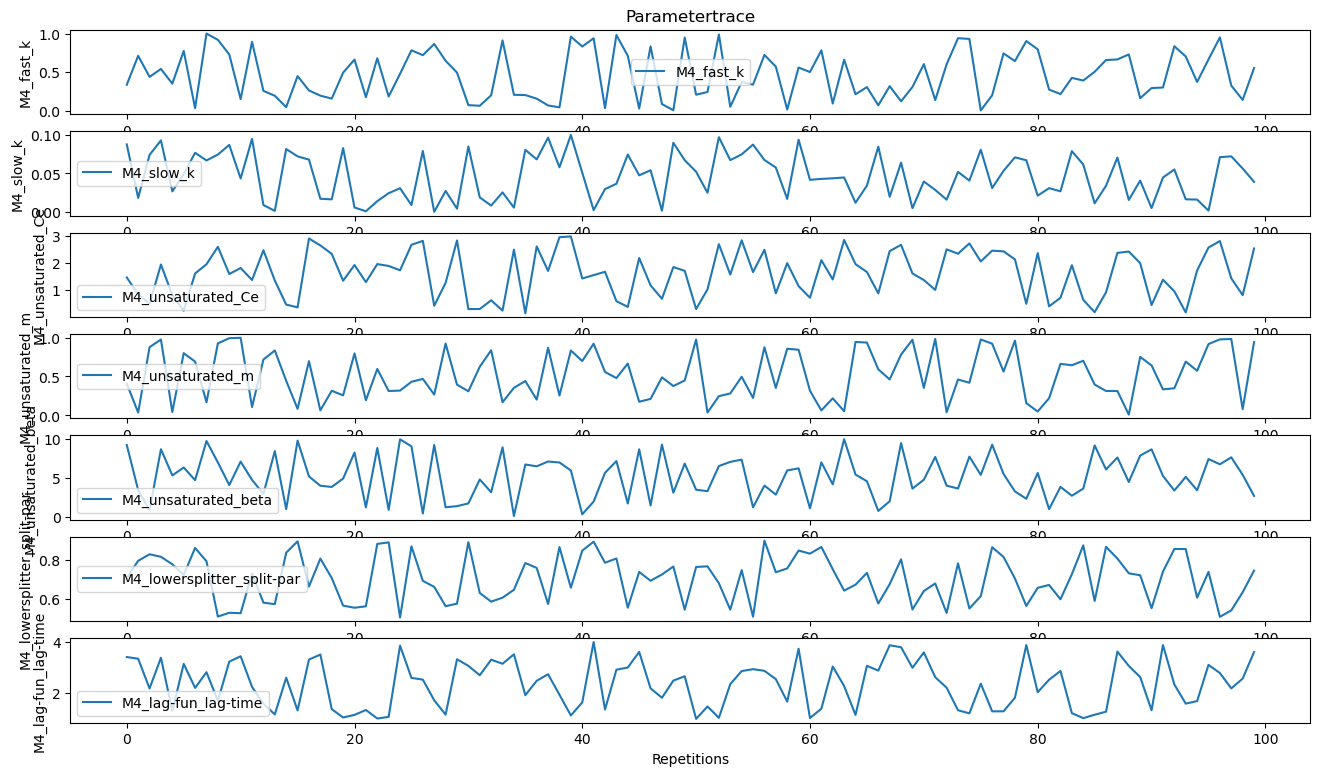

In [229]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function


spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')


# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

In [230]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output

{'FR003237': [array([0.       , 0.       , 0.       , ..., 0.9779384, 0.8822136,
         0.8277528])],
 'DERP2004': [array([0.        , 0.        , 0.        , ..., 1.16204832, 0.97633237,
         0.89073681])],
 'FR003253': [array([0.        , 0.        , 0.        , ..., 1.43511518, 0.85617145,
         0.60206057])],
 'BEWA0067': [array([0.        , 0.        , 0.        , ..., 1.41740192, 1.18375747,
         1.07548902])],
 'BEWA0087': [array([0.        , 0.        , 0.        , ..., 1.03738161, 0.97423662,
         0.94316756])],
 'BEWA0106': [array([0.        , 0.        , 0.        , ..., 0.96583899, 0.80131625,
         0.72098796])],
 'BEWA0107': [array([0.        , 0.        , 0.        , ..., 1.4156996 , 1.21982719,
         1.13757455])]}

In [231]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2004"]
Qtimeseries["Qcalc"] = output["DERP2004"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.277497132819553

<Axes: >

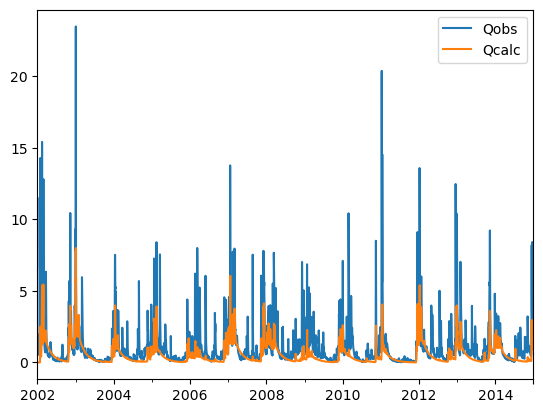

In [232]:
Qtimeseries.plot()

In [233]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003237"]
Qtimeseries["Qcalc"] = output["FR003237"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.22090003652467938

<Axes: >

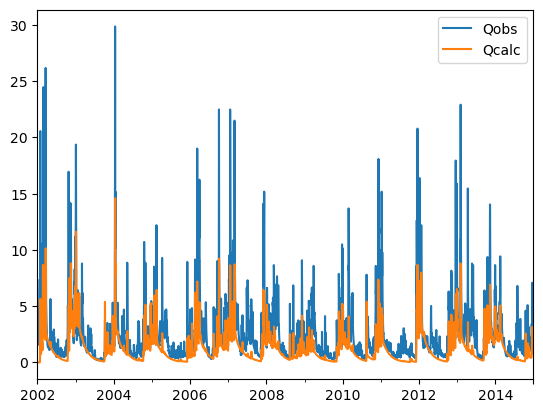

In [234]:
Qtimeseries.plot()

In [235]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.34017185463861543

In [237]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0067"]
Qtimeseries["Qcalc"] = output["BEWA0067"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.3298919920548776

In [238]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0087"]
Qtimeseries["Qcalc"] = output["BEWA0087"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-8.147261414435425

In [239]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0106"]
Qtimeseries["Qcalc"] = output["BEWA0106"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.31623415270591704

In [240]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0107"]
Qtimeseries["Qcalc"] = output["BEWA0107"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.46427866841461596

In [ ]:



best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])


In [101]:
results[bestindex]

(0.21799583, 0.26215353, 0.03040796, 1.04298502, 0.30325854, 4.89524188, 0.54104064, 2.96090588, 0., 0., 0., 0., 0., 0., 3.22830274e-09, 3.22830315e-09, 3.22830484e-09, 3.22830484e-09, 3.22830484e-09, 4.83473582e-09, 9.26305152e-09, 9.26305704e-09, 9.26306495e-09, 2.46473382e-07, 2.39202513e-07, 8.67886741e-06, 0.00025929, 0.00404235, 0.0062661, 0.01236216, 0.03278941, 0.1079614, 0.29851124, 1.01452128, 2.670107, 5.14868331, 5.2868262, 2.81678834, 1.59637771, 1.20727177, 1.05250243, 0.91586989, 0.81070585, 0.92893766, 1.27789203, 1.8606845, 2.2005742, 3.47513916, 4.78386541, 6.50633744, 6.62457777, 8.85677967, 9.48615831, 5.56301823, 3.07196287, 2.26184297, 2.09884728, 3.12060445, 6.22657207, 9.48440121, 8.1368917, 5.22019468, 5.7498476, 6.6664143, 8.29846701, 9.32693118, 7.47366003, 4.74975664, 3.63532758, 2.98653908, 2.66623446, 2.47873928, 2.41831956, 2.4250216, 2.48349846, 2.3148532, 2.16848808, 2.0610354, 1.96877264, 1.91439893, 1.95823485, 2.06843085, 2.17012699, 1.94399276, 1.99

In [ ]:



import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):
        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            catchments (list): List of Node objects.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._catchments = catchments  # Use predefined catchments list
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the simulation for all nodes using the same parameter set."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        outputs = {}  # Store simulation results for each node

        for cat in self._catchments:  # Iterate over manually defined catchments
            cat.set_parameters(named_parameters)  # Apply shared parameters

            # Generate input data
            P = np.zeros(100)
            P[:10] = np.random.randint(10, size=10)
            P[25:30] = np.random.randint(20, size=5)
            P[40:60] = np.random.randint(5, size=20)
            P[80:83] = np.random.randint(30, 50, size=3)

            E = np.ones_like(P) * 2.0  # Constant PET
            T = (np.random.rand(100) - 0.2) * 20  # Random Temperature

            cat.set_input([P, T, E])  # Directly set input for each node
            cat.set_timestep(self._dt)
            cat.reset_states()  # Reset internal states

            output = cat.get_output()
            outputs[cat.id] = output[self._output_index]  # Store results for each node

        return outputs  # Dictionary with outputs for each node

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for node_id in simulation.keys():
            # Apply warm-up period
            sim = simulation[node_id][self._warm_up + 1:]
            obs = evaluation[node_id][self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error


In [70]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [71]:
DERP2004.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=DERP2004,
    inputs=[P, T, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        #spotpy.parameter.Uniform('M4_snow_k', 0.0, 1.0),

    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'], #"M4_snow_k"
    output_index=0
)

In [72]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=100)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 100, minimal objective function=0.565567, time remaining: 00:03:14
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
47 of 100, minimal objective function=0.312685, time remaining: 00:00:06
93 of 100, minimal objective function=0.306699, time remaining: 00:00:01
Stopping samplig. Maximum number of repetitions reached already during burn-in
Burn-in sampling completed...
*** OPTIMIZATION SEARCH TERMINATED BECAUSE THE LIMIT
ON THE MAXIMUM NUMBER OF TRIALS 
100
HAS BEEN EXCEEDED.  SEARCH WAS STOPPED AT TRIAL NUMBER:
100
OF THE INITIAL LOOP!
Starting Complex Evolution...
SEARCH WAS STOPPED AT TRIAL NUMBER: 100
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.995276
THE BEST POINT HAS IMPROVED IN LAST 100 LOOPS BY 100000.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 8.34 seconds
Tot

The figure as been saved as "Parameter_trace.png
Run number 2035 has the lowest objectivefunction with: 0.202


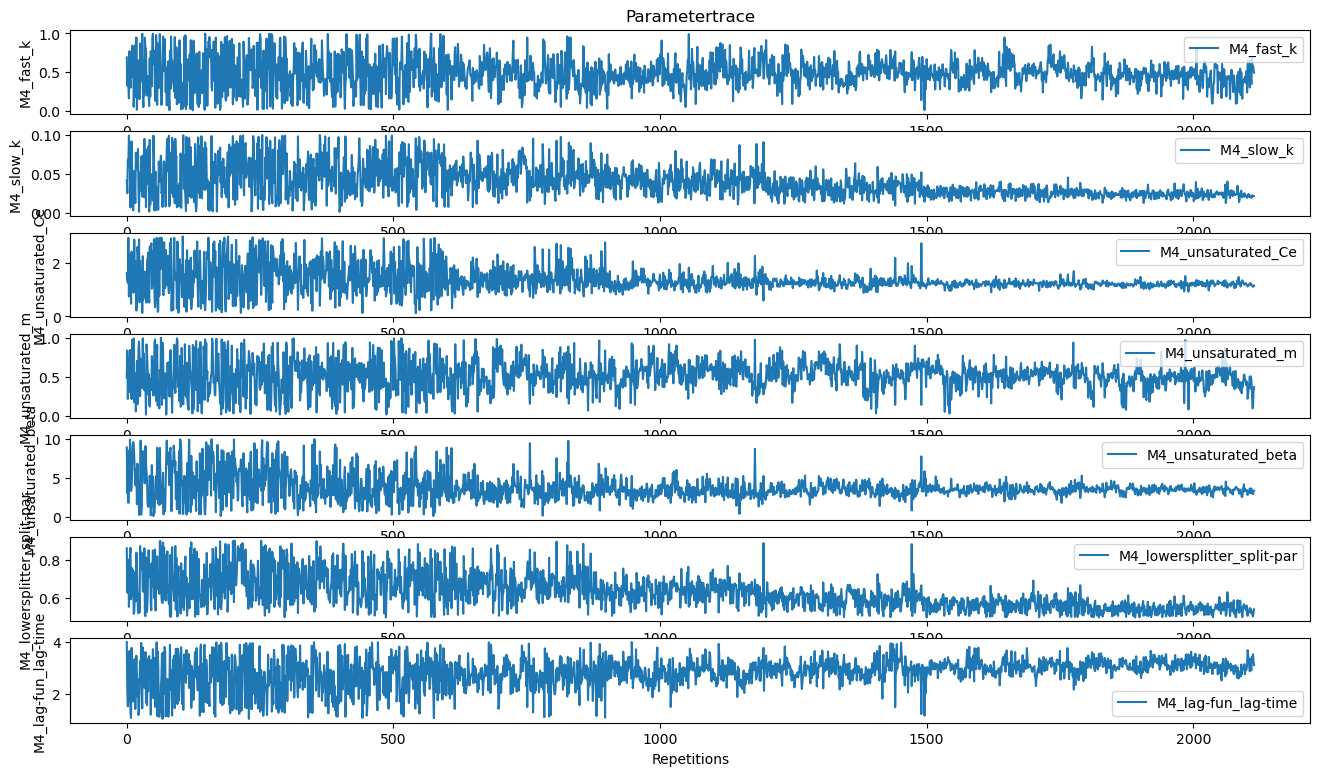

In [622]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [623]:
best_model_run

(0.20200061, 0.12008787, 0.0198779, 1.22223028, 0.39998824, 3.19294541, 0.51119517, 3.0028395, 0., 0., 0., 0., 0., 0., 3.54544801e-08, 3.47635228e-08, 3.40862573e-08, 3.34219086e-08, 3.2770507e-08, 5.21709113e-08, 1.08241492e-07, 1.06132973e-07, 1.04066199e-07, 3.37398075e-06, 3.30886324e-06, 8.88586634e-05, 0.00125214, 0.00929014, 0.01743471, 0.04064369, 0.07508837, 0.17258437, 0.39702485, 1.00007245, 2.30194319, 4.51820682, 4.97038484, 2.9338087, 1.72997976, 1.261859, 1.05027737, 0.88472904, 0.75497195, 0.81379401, 1.08079594, 1.55596908, 1.86087039, 2.91158524, 4.13663756, 5.86325392, 6.08912922, 8.20314217, 9.15761393, 5.65865208, 3.11695368, 2.15255576, 1.85928087, 2.58365745, 5.2096476, 8.5270946, 7.75610952, 5.02709266, 5.29747893, 6.00473094, 7.47724821, 8.64316058, 7.13361208, 4.5425116, 3.33914416, 2.61832611, 2.25067126, 2.04148448, 1.96606056, 1.97513781, 2.04646186, 1.91202072, 1.79043339, 1.7035145, 1.63032868, 1.59239431, 1.63681642, 1.75182816, 1.86531227, 1.69845856, 1

In [624]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

0.7985578052913354

In [625]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.6466534156753938

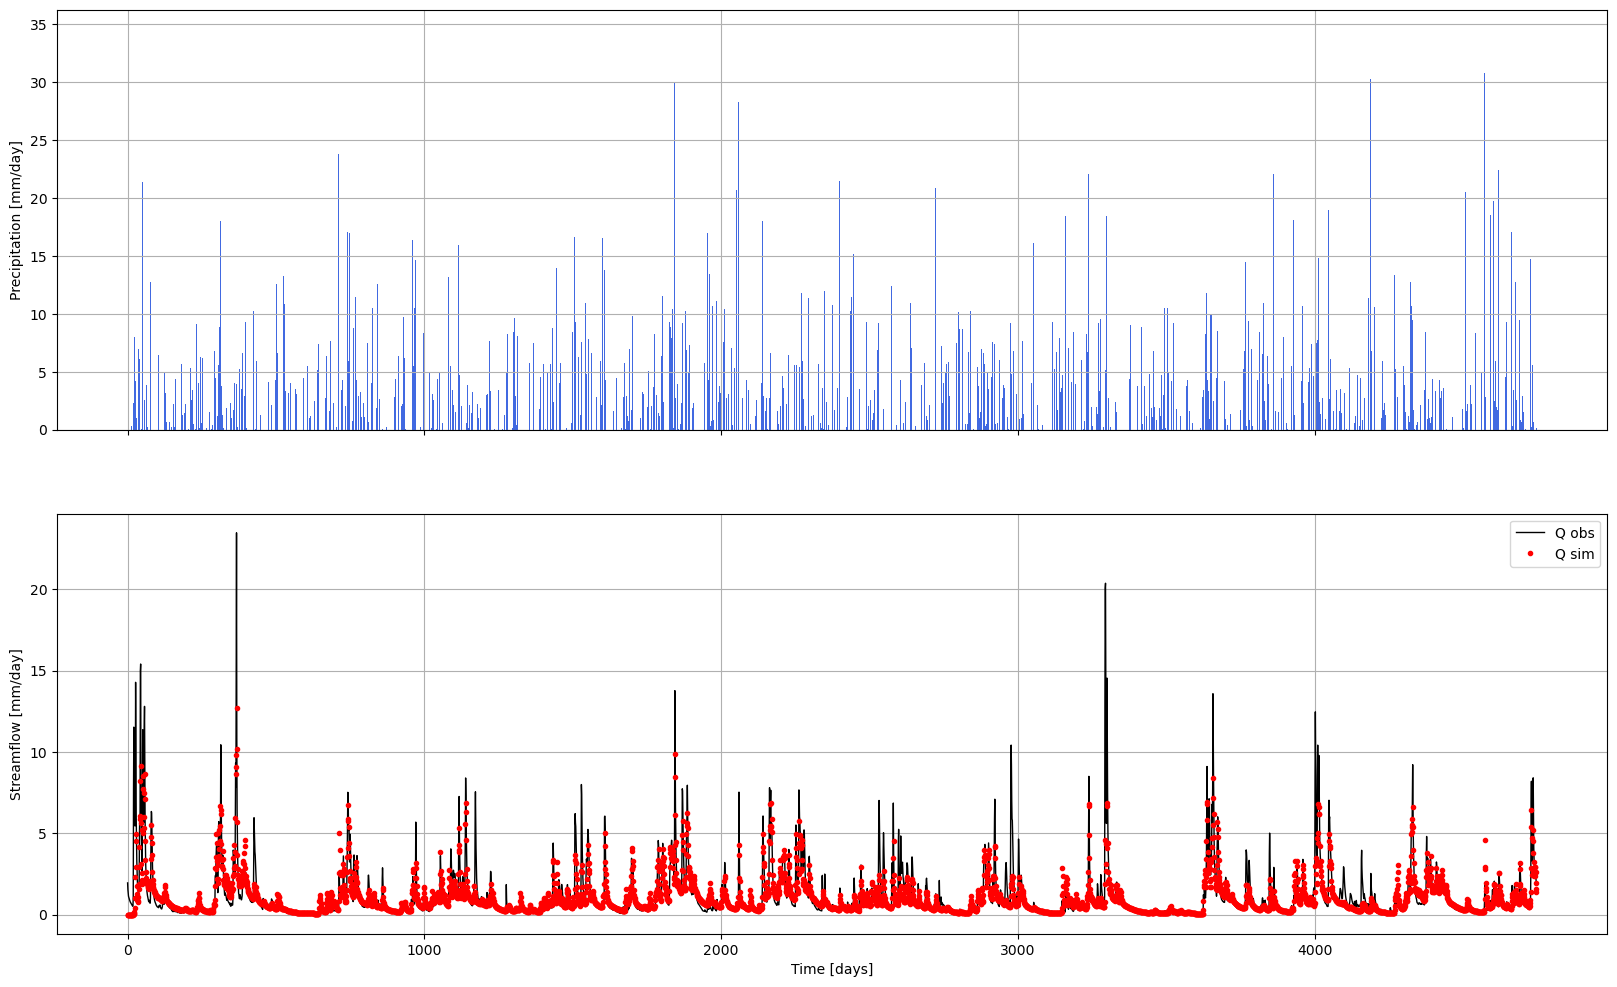

In [626]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [627]:
best_params_dict

{'M4_fast_k': 0.1200878726168807,
 'M4_slow_k': 0.0198778976594689,
 'M4_unsaturated_Ce': 1.2222302759799968,
 'M4_unsaturated_m': 0.39998823861160615,
 'M4_unsaturated_beta': 3.1929454065223943,
 'M4_lowersplitter_split-par': 0.5111951674708165,
 'M4_lag-fun_lag-time': 3.0028394978328286}

In [637]:
#best_params_dict['M4_lowersplitter_split-par'] = 0.5
best_params_dict['M4_fast_k'] = 1.0
#best_params_dict['M4_slow_k'] = 0.01
#best_params_dict['M4_snow_k'] = 0.01
#best_params_dict['M4_lag-fun_lag-time'] = 3.0
#best_params_dict['M4_unsaturated_beta'] = 5.0

In [638]:
hyd_mod.reset_states()
hyd_mod.set_input([P,T, E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

[array([0.        , 0.        , 0.        , ..., 1.53705382, 1.24153621,
        1.12653391])]

In [639]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

,Qobs,Qcalc
2002-01-01,1.950238,0.000000
2002-01-02,1.534647,0.000000
2002-01-03,1.293373,0.000000
2002-01-04,1.131966,0.000000
2002-01-05,1.063647,0.000000
...,...,...
2014-12-27,2.787952,3.007358
2014-12-28,2.714421,2.524129
2014-12-29,2.269552,1.537054
2014-12-30,2.025230,1.241536


In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2001', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

ValueError: Length of values (4748) does not match length of index (5113)

In [640]:
data_comparation = Qtimeseries.copy()

data_comparation

,Qobs,Qcalc
2002-01-01,1.950238,0.000000
2002-01-02,1.534647,0.000000
2002-01-03,1.293373,0.000000
2002-01-04,1.131966,0.000000
2002-01-05,1.063647,0.000000
...,...,...
2014-12-27,2.787952,3.007358
2014-12-28,2.714421,2.524129
2014-12-29,2.269552,1.537054
2014-12-30,2.025230,1.241536


ValueError: zero-size array to reduction operation fmin which has no identity

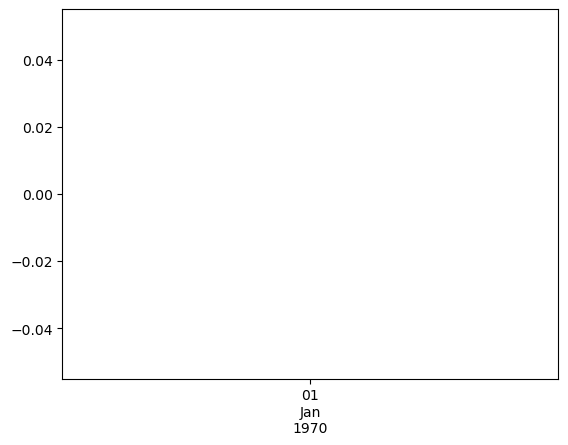

In [641]:
data_comparation.loc["1995-02-01":"1995-06-01"].plot()

<Axes: >

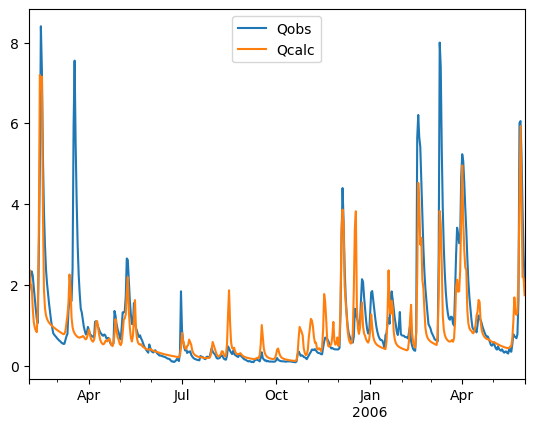

In [642]:
data_comparation.loc["2005-02-01":"2006-06-01"].plot()

In [643]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7803191635265792

In [644]:
network_estreams.loc[basin_id, :]

gauge_id                                                      2626030300
gauge_name                                                    GemuendOur
gauge_country                                                         DE
gauge_provider                                                     DE_RP
river                                                                Our
lon_snap                                                           6.171
lat_snap                                                          49.985
lon                                                                6.171
lat                                                               49.985
elevation                                                            NaN
area_official                                                      613.4
area_estreams                                                      615.0
area_flag                                                              0
area_rel                                           